# Test point assigner

* Code partially taken from [Oriented RepPoints](https://github.com/LiWentomng/OrientedRepPoints/tree/main/mmdet/ops).

In [2]:
%reload_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from random import randint

from obb.utils.box_ops import *
from obb.model.oriented_reppoints_loss import *
from obb.utils.dataset import Dataset

In [3]:
# Load sample image
img_idx = 1

train_dataset = Dataset(path='../assets/DOTA_sample_data/split')
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

for idx, (curr_img, curr_obb, curr_object_class) in enumerate(train_data_loader):
    if idx == img_idx:
        img, obb, object_class = curr_img, curr_obb.squeeze(), curr_object_class.squeeze()
        break

print(img.shape)

torch.Size([1, 3, 512, 512])


tensor([-231.5000, -166.7500]) tensor(8.)
tensor([-1.7500,  3.5000]) tensor(8.)
tensor([2., 0.]) tensor(8.)
tensor([3.5000, 5.5000]) tensor(8.)
tensor([ 1.2500, -3.7500]) tensor(8.)
tensor([-0.7500,  3.2500]) tensor(8.)
tensor([-3., -4.]) tensor(8.)
tensor([ 1.7500, -0.2500]) tensor(8.)
tensor([ 1.0000, -0.5000]) tensor(8.)
tensor([1.2500, 3.7500]) tensor(8.)
tensor([-2.,  3.]) tensor(8.)
tensor([3.5000, 0.7500]) tensor(8.)
tensor([-3.7500,  2.0000]) tensor(8.)
tensor([ 3.2500, -2.5000]) tensor(8.)
tensor([-2.5000,  0.5000]) tensor(8.)
tensor([-4.0000,  0.2500]) tensor(8.)
tensor([-2.0000,  2.2500]) tensor(8.)
tensor([1.5000, 3.2500]) tensor(8.)
tensor([-2.7500, -2.0000]) tensor(8.)
tensor([-0.2500,  2.0000]) tensor(8.)
tensor([1.7500, 0.5000]) tensor(8.)
tensor([ 0.2500, -2.5000]) tensor(8.)
tensor([-3.,  4.]) tensor(8.)
tensor([1.7500, 2.0000]) tensor(8.)
tensor([-3.5000, -2.2500]) tensor(8.)
tensor([-1.0000, -1.7500]) tensor(8.)
tensor([-3.5000, -3.7500]) tensor(8.)
tensor([ 2.5000,

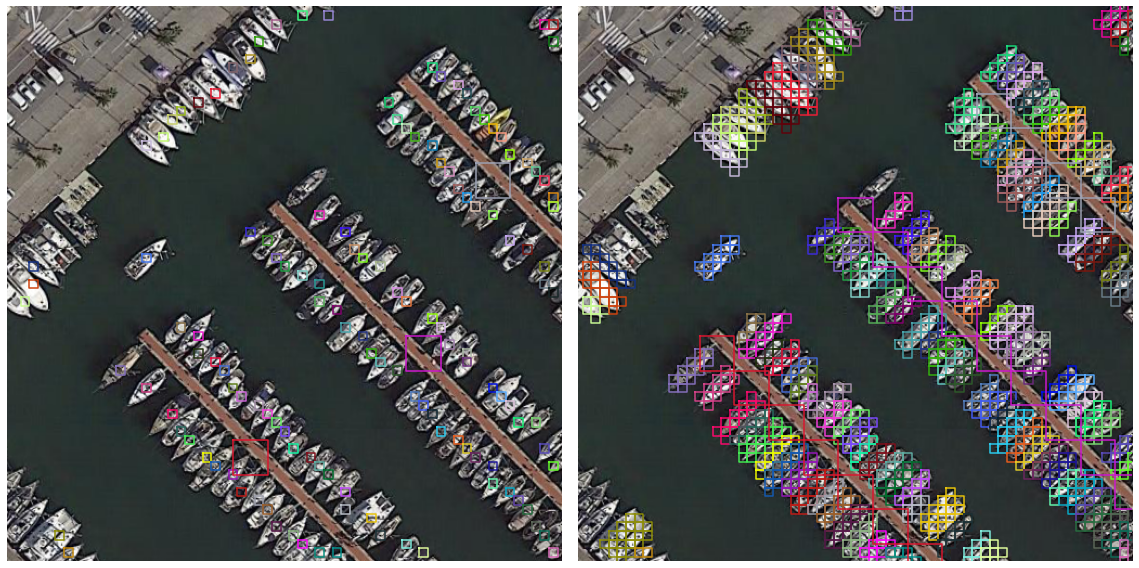

In [10]:
# Assign cells in feature maps to gt objects
b, xy, (h, w) = 1, 18, img.shape[2:]
lvls = [3, 4, 5]
strides = [2 ** lvl for lvl in lvls]
colors = ['#%06X' % randint(0, 0xFFFFFF) for _ in obb]
stride_dict = {f'P{lvl}': stride for lvl, stride in zip(lvls, strides)}
feature_map_dict = {f'P{lvl}': torch.rand(b, xy, h, w) for lvl in lvls}

model_loss = OrientedRepPointsLoss(stride_dict)
simple_assigner = SimpleAssigner()
point_assigner = OBBPointAssigner()

centers, _ = model_loss._get_centers(feature_map_dict, feature_map_dict)
simple_assigned_gt_idxs, simple_assigned_labels = simple_assigner.assign(centers, obb, object_class)
point_assigned_gt_idxs, point_assigned_labels = point_assigner.assign(centers, obb, object_class)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

for i in range(len(centers)):
    if point_assigned_labels[i] != 0:
        x, y, stride = centers[i]
        square = torch.Tensor([[x - 0.5 * stride, y - 0.5 * stride],
                               [x + 0.5 * stride, y - 0.5 * stride],
                               [x + 0.5 * stride, y + 0.5 * stride],
                               [x - 0.5 * stride, y + 0.5 * stride]])
        ax1.plot(torch.cat((square[:, 0], square[0, 0].reshape(1))), torch.cat((square[:, 1], square[0, 1].reshape(1))), color=colors[point_assigned_gt_idxs[i] - 1])

for i in range(len(centers)):
    if simple_assigned_labels[i] != 0:
        x, y, stride = centers[i]
        square = torch.Tensor([[x - 0.5 * stride, y - 0.5 * stride],
                               [x + 0.5 * stride, y - 0.5 * stride],
                               [x + 0.5 * stride, y + 0.5 * stride],
                               [x - 0.5 * stride, y + 0.5 * stride]])
        ax2.plot(torch.cat((square[:, 0], square[0, 0].reshape(1))), torch.cat((square[:, 1], square[0, 1].reshape(1))), color=colors[simple_assigned_gt_idxs[i] - 1])

ax1.imshow(img.squeeze().permute(1, 2, 0).numpy())
ax2.imshow(img.squeeze().permute(1, 2, 0).numpy())
ax1.set_axis_off()
ax2.set_axis_off()
plt.tight_layout()